In [154]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
import argparse
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import PIL.Image as pil_image
from torchvision.transforms import ToTensor, ToPILImage
from typing import Tuple
import cv2

# 定义 SRCNN 模型
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

def convert_rgb_to_ycbcr(img):
    if isinstance(img, np.ndarray):
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif isinstance(img, torch.Tensor):
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.stack([y, cb, cr], dim=0)
    else:
        raise Exception('未知的类型', type(img))

def convert_ycbcr_to_rgb(img):
    if isinstance(img, np.ndarray):
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif isinstance(img, torch.Tensor):
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.stack([r, g, b], dim=0)
    else:
        raise Exception('未知的类型', type(img))

def load_image(filepath: str) -> torch.Tensor:
    img = pil_image.open(filepath).convert('RGB')  # 确保图像为 RGB
    img_tensor = ToTensor()(img).unsqueeze(0)  # 转换为张量并添加批次维度
    # print(img_tensor)
    return img_tensor

def save_image(tensor: torch.Tensor, filepath: str):
    tensor = tensor.clamp(0, 1)  # 确保张量值在 [0, 1] 范围内
    img = ToPILImage()(tensor.squeeze(0))  # 去除批次维度并转换为 PIL 图像
    img.save(filepath)

def resize_image_with_srcnn(input_tensor: torch.Tensor, output_size: Tuple[int, int], model: nn.Module) -> torch.Tensor:
    device = torch.device("cpu")
    input_tensor = input_tensor.to(device)
    # print(input_tensor)

    # 转换 RGB 为 YCbCr
    ycbcr = convert_rgb_to_ycbcr(input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
    y = ycbcr[..., 0]
    cb = ycbcr[..., 1]
    cr = ycbcr[..., 2]
    y /= 255.0
    y = torch.from_numpy(y).unsqueeze(0).unsqueeze(0).to(device)

    # 使用双三次插值法调整 Y 通道到目标大小
    y_resized = F.interpolate(y, size=output_size, mode='bicubic', align_corners=True)

    # 对 Y 通道进行超分辨率处理
    model.eval()
    with torch.no_grad():
        preds_y = model(y_resized).clamp(0.0, 1.0)

    # 将 preds_y 调整为与 output_size 匹配
    preds_y = preds_y.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

    # 确保 cb 和 cr 与 preds_y 尺寸相同
    cb_resized = cv2.resize(cb, output_size, interpolation=cv2.INTER_CUBIC)
    cr_resized = cv2.resize(cr, output_size, interpolation=cv2.INTER_CUBIC)

    # 创建输出的 YCbCr 图像
    output = np.array([preds_y, cb_resized, cr_resized]).transpose([1, 2, 0])
    # print(output)
    output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)

    output_image = pil_image.fromarray(output)


    return output_image

def main(input_filepath: str, output_filepath: str, output_size: Tuple[int, int], weights_file: str):
    # 加载输入图像
    input_tensor = load_image(input_filepath)*255
    # print(input_tensor)

    # 设置设备和模型
    device = torch.device('cpu')
    model = SRCNN().to(device)

    # 加载预训练权重
    model.load_state_dict(torch.load(weights_file, map_location=device))

    # 执行超分辨率处理
    output_image = resize_image_with_srcnn(input_tensor, output_size, model)
    output_image_array= np.array(output_image)
    # print(output_image_array.shape)

    # 保存输出图像
    output_image.save(output_filepath)



In [177]:
from templates import *
from ssim import *
import torch
import torch.fft as fft
def add_gaussian_noise(image, mean=0, sigma=25):

    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = np.clip(image + gauss, 0, 255).astype(np.uint8)
    return noisy_image

def SNR_to_noise(snr):
    snr = 10 ** (snr / 10)
    noise_std = 1 / np.sqrt(2 * snr)
    return noise_std


def AWGN(Tx_sig, n_var,device):
    Rx_sig = Tx_sig + torch.normal(0, n_var, size=Tx_sig.shape).to(device)
    return Rx_sig



In [178]:

def to256(data):
   data_np = data.cpu().numpy()
   min_val = np.min(data_np)
   max_val = np.max(data_np)
   scaled_data = (data_np - min_val) / (max_val - min_val) * 255
   scaled_data_tensor = torch.from_numpy(scaled_data)
   return scaled_data_tensor,min_val,max_val

def to1(data,min_val,max_val):
   scaled_data_np = data.cpu().numpy()
   restored_data = (scaled_data_np / 255) * (max_val - min_val) + min_val
   restored_data_tensor = torch.from_numpy(restored_data)
   return restored_data_tensor

In [159]:
device = 'cpu'
conf =ffhq128_autoenc_72M()
#conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 122.59 M


128


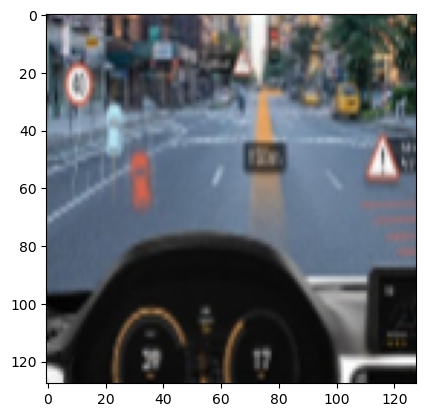

In [160]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
print(data)
batch = data[7]['img'][None]   #[0]

import matplotlib.pyplot as plt

# 获取原始图像的像素大小
width, height = batch[0].permute([1, 2, 0]).shape[1], batch[0].permute([1, 2, 0]).shape[0]
print(width)
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

# from PIL import Image
# import numpy as np
# # 将Tensor转换为NumPy数组，并将像素值缩放到0到1的范围内
# image_data = (batch[0].permute([1, 2, 0]).cpu().numpy() / 2 + 0.5).clip(0, 1)
# # 将NumPy数组转换为PIL图像对象
# image = Image.fromarray((image_data * 255).astype(np.uint8))
# # 保存图像为JPEG格式
# image.save("/home/liujian/diffae-master/output00003.jpg")



# Encode

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 89, 89])
torch.Size([1, 512])
torch.Size([1, 3, 89, 89])
Encoder success
0.3976353643835253
Transmit success


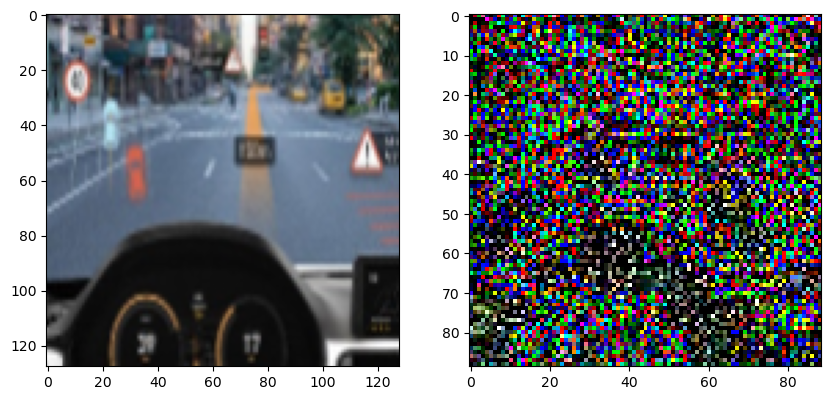

In [207]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=10)
print(cond.shape)
print(xT.shape)
print("Encoder success")   ###############完成encoder
SNR=5
noise_std=SNR_to_noise(SNR)
print(noise_std)
cond256=AWGN(cond*128,noise_std,device)
cond=cond256/128
xT256 =AWGN(xT*128 ,noise_std,device)
xT=xT256/128
print("Transmit success")
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

from PIL import Image
import numpy as np
# print(xT[0].shape)   #3, 89, 89
xT_np = (xT[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
xT_img = Image.fromarray(xT_np)   #(rgb,89,389,3)
# print(xT_np.shape)   
# 保存图像为 PNG 文件
xT_img.save("/home/liujian/SRCNN-pytorch-master/output_lunkou.jpg")

# Decode

In [211]:
# 基于插值的超分
# xT = F.interpolate(xT, size=[128,128], mode='bicubic', align_corners=False)     
# print(xT.shape)
#基于神经网络超分
# print(xT.shape)
xT_np = (xT[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
xT_img = Image.fromarray(xT_np)   #(rgb,89,389,3)
input_lunkou='/home/liujian/SRCNN-pytorch-master/output_lunkou.jpg'
output_lunkou='/home/liujian/SRCNN-pytorch-master/output_lunkou_128_128.jpg'
cudnn.benchmark = True
main(input_lunkou, output_lunkou, (128,128),'/home/liujian/SRCNN-pytorch-master/srcnn_x2.pth')
img_128lunkou = Image.open("/home/liujian/SRCNN-pytorch-master/output_lunkou_128_128.jpg")
tensor = ToTensor()(img_128lunkou).unsqueeze(0)
print(tensor.shape)
xT=tensor
print(tensor)
# xT = torch.randn(1, 3, 128, 128)
# xT = xT.to(torch.float16).to(device)

torch.Size([1, 3, 128, 128])
tensor([[[[0.5333, 0.5765, 0.9569,  ..., 0.2235, 0.3176, 0.3216],
          [0.3020, 0.0627, 0.4784,  ..., 0.0000, 0.0000, 0.0000],
          [0.4000, 0.0157, 0.7333,  ..., 0.0392, 0.3137, 0.3451],
          ...,
          [0.3490, 0.9294, 0.0706,  ..., 0.8863, 0.2000, 0.0000],
          [0.4157, 0.8941, 0.2549,  ..., 0.6824, 0.4902, 0.0235],
          [0.2000, 0.1098, 0.1333,  ..., 0.3804, 0.5098, 0.5843]],

         [[0.7922, 0.5137, 0.4863,  ..., 0.3686, 0.7412, 0.9804],
          [0.6627, 0.1059, 0.1333,  ..., 0.0353, 0.2118, 0.3569],
          [0.8745, 0.2078, 0.5569,  ..., 0.1294, 0.4235, 0.4784],
          ...,
          [0.5608, 1.0000, 0.0627,  ..., 1.0000, 0.3725, 0.0863],
          [0.7176, 1.0000, 0.2706,  ..., 0.9412, 0.7882, 0.3255],
          [0.5569, 0.3294, 0.1608,  ..., 0.7373, 0.9059, 0.9843]],

         [[0.5098, 0.3216, 0.4314,  ..., 0.4039, 0.7882, 1.0000],
          [0.3294, 0.0000, 0.0549,  ..., 0.0980, 0.3176, 0.4745],
          [0.

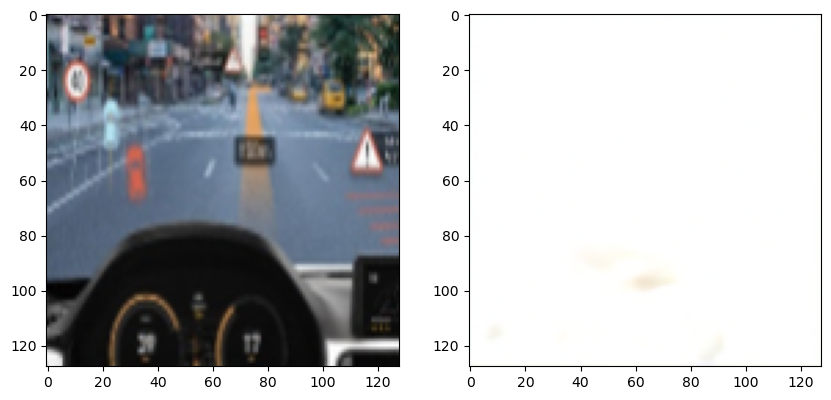

In [209]:

pred = model.render(xT, cond, T=30)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu()) 
from PIL import Image
import numpy as np
pred_np = (pred[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

pred_img = Image.fromarray(pred_np)

# 保存图像为 PNG 文件
# pred_img.save("/home/liujian/111.png")


ssim= tensor(0.7766)


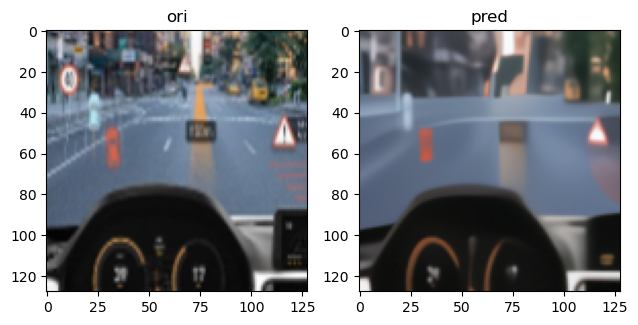

PSNR值: 22.968593924372783 dB


In [206]:
import matplotlib.pyplot as plt # plt 用于显示图片
from PIL import Image
img1 = ori[0].cpu()      #[3,128,128]
img2 = pred[0].cpu()     #[3,128,128]
ssim_score=ssim(img1,img2)
print('ssim=',ssim_score)
img1 = ori[0].permute(1, 2, 0).cpu()
img2 = pred[0].permute(1, 2, 0).cpu()
#结果展示
plt.subplot(121)
plt.imshow(img1)
plt.title('ori')
#不显示坐标轴
#plt.axis('off')
#子图2
plt.subplot(122)
plt.imshow(img2)
plt.title('pred')
#plt.axis('off')
# #设置子图默认的间距
plt.tight_layout()
#显示图像
plt.show()
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
img1_np = img1.cpu().numpy()
img2_np = img2.cpu().numpy()
# 使用 skimage 库计算 PSNR
psnr_value = peak_signal_noise_ratio(img1_np, img2_np)
print(f"PSNR值: {psnr_value} dB")


In [14]:
import torch
import lpips
from PIL import Image
#计算lpips 指标  越低越好
# 加载预训练的LPIPS模型
lpips_model = lpips.LPIPS(net="alex")
# 将图像转换为PyTorch的Tensor格式
image1_tensor = torch.tensor(np.array(img1_np)).permute(2, 0, 1).unsqueeze(0).float() / 255.0

print(image1_tensor.size())
image2_tensor = torch.tensor(np.array(img2_np)).permute(2, 0, 1).unsqueeze(0).float() / 255.0
# 使用LPIPS模型计算距离
distance = lpips_model(image1_tensor, image2_tensor)
print("LPIPS distance:", distance.item())



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/liujian/anaconda3/envs/msc39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/liujian/anaconda3/envs/msc39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/liujian/anaconda3/envs/msc39/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 128, 128])
LPIPS distance: 2.825069032041938e-07
